In [1]:
import math
import time

import numpy as np
import pandas as pd
import requests
import datetime
from tabulate import tabulate
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

C:\Users\yashd\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def get_encoded_period(p_date, p_month, p_year):
    return int(time.mktime(datetime.datetime(p_year, p_month, p_date, 8, 30).timetuple()))


def get_delta_date(number_of_days):
    tomorrows_date = (str(datetime.date.today() + datetime.timedelta(days=number_of_days))).split('-')
    temp_year = int(tomorrows_date[0])
    temp_month = int(tomorrows_date[1])
    temp_day = int(tomorrows_date[2])
    # print(temp_year, temp_month, temp_day)
    return int(time.mktime(datetime.datetime(temp_year, temp_month, temp_day, 23, 59).timetuple()))


def prepare_url(p_ticker, period1, period2, p_interval):
    interval = '1d'
    if p_interval == 'daily':
        interval = '1d'
    elif p_interval == 'weekly':
        interval = '1wk'
    elif p_interval == 'monthly':
        interval = '1mo'
    return f'https://query1.finance.yahoo.com/v7/finance/download/{p_ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'


def get_data_from_yahoo_finance(p_url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) '
                      'Chrome/50.0.2661.102 Safari/537.36 '
    }
    # return requests.get(p_url, headers=headers).text
    response = requests.get(p_url, headers=headers).text
    # print(response)
    return response


def prepare_dataframe(p_response):
    list_date = []
    list_open = []
    list_high = []
    list_low = []
    list_close = []
    list_adj_close = []
    list_volume = []

    # print(p_response)

    array_data = p_response.split('\n')
    # print('array_data', array_data)

    for i in range(1, len(array_data)):
        if array_data[i].split(',')[1] != 'null':
            list_date.append(array_data[i].split(',')[0])
            list_open.append(math.ceil(float(array_data[i].split(',')[1])))
            list_high.append(float(array_data[i].split(',')[2]))
            list_low.append(float(array_data[i].split(',')[3]))
            list_close.append(math.ceil(float(array_data[i].split(',')[4])))
            list_adj_close.append(float(array_data[i].split(',')[5]))
            list_volume.append(float(array_data[i].split(',')[6]))

    temp_df = pd.DataFrame(list(zip(list_date, list_open, list_high, list_low, list_close, list_adj_close, list_volume)))
    columns = array_data[0].split(',')
    # print(columns)
    temp_df.columns = columns

    return temp_df


def print_dataframe(p_dataframe):
    print(tabulate(p_dataframe, headers="keys", tablefmt="psql"))


def fetch_data_last_5_years(ticker):
    period1 = get_encoded_period(1, 1, 2019)
    period2 = get_delta_date(-30)
    url = prepare_url(ticker, period1, period2, p_interval='daily')
    return prepare_dataframe(get_data_from_yahoo_finance(url))

In [3]:
df = fetch_data_last_5_years('TCS.NS')

In [4]:
# print_dataframe(df)

In [5]:
df_close = df.reset_index()['Close']

In [6]:
df_close

0       1903
1       1924
2       1900
3       1877
4       1898
        ... 
1309    3875
1310    3832
1311    3853
1312    3822
1313    3871
Name: Close, Length: 1314, dtype: int64

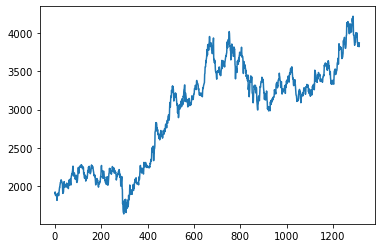

In [7]:
plt.plot(df_close)

In [8]:
scaler = MinMaxScaler(feature_range=(0,1))
df_close = scaler.fit_transform(np.array(df_close).reshape(-1,1))

In [9]:
training_size = int(len(df_close)*0.65)
test_size = len(df_close) - training_size
train_data, test_data = df_close[0:training_size,:], df_close[training_size:len(df_close),:1]

In [10]:
training_size,test_size

(854, 460)

In [11]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [12]:
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [13]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [14]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 30, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100

13/13 [==============================] - 121s 3s/step - loss: 0.0561 - val_loss: 0.0365
Epoch 2/100
13/13 [==============================] - 4s 322ms/step - loss: 0.0102 - val_loss: 0.0025
Epoch 3/100
13/13 [==============================] - 4s 302ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 4/100
13/13 [==============================] - 4s 327ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 5/100
13/13 [==============================] - 4s 294ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 6/100
13/13 [==============================] - 4s 313ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 7/100
13/13 [==============================] - 4s 296ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 8/100
13/13 [==============================] - 4s 300ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 9/100
13/13 [==============================] - 4s 275ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 10/100
13/13 [==============================] - 5s 382ms/step - loss: 0.0021 - val_lo

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [ ]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [ ]:
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

In [ ]:
math.sqrt(mean_squared_error(ytest,test_predict))

In [ ]:
look_back = time_step
trainPredictPlot = np.empty_like(df_close)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df_close)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df_close)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df_close))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
len(test_data)

In [ ]:
x_input=test_data[(len(test_data) - time_step):].reshape(1, -1)
x_input.shape

In [ ]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [ ]:
from numpy import array

lst_output = []
n_steps = time_step
i = 0
while(i < 30):
    if(len(temp_input) > time_step):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
#         print(yhat[0])
        temp_input.extend(yhat[0].tolist())
#         print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i = i+1


In [ ]:
# day_new=np.arange(1,11)
# day_pred=np.arange(11,41)

day_new=np.arange(1, (1 + time_step))
day_pred=np.arange((1 + time_step), (1 + time_step + 30))

In [ ]:
len(df_close)

In [ ]:
plt.plot(day_new,scaler.inverse_transform(df_close[(len(df_close) - time_step):]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

In [ ]:
df3 = df_close.tolist()
df3.extend(lst_output)
plt.plot(df3[1000:])

In [ ]:
df3 = scaler.inverse_transform(df3).tolist()

In [ ]:
plt.plot(df3)